# IF3270 Machine Learning | Tugas Besar 2


Group Number: 46

Group Members:
- Ariel Herfrison (13522002)
- Zachary Samuel Tobing (13522016)
- Imam Hanif Mulyarahman (13522030)

## Import Libraries

In [ ]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, TextVectorization
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
import os


In [62]:
# Seeding for determinism

seed = 42
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
keras.utils.set_random_seed(42)

## Import Dataset

In [22]:
url_train = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/train.csv"
train = pd.read_csv(url_train)

url_val = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/valid.csv"
val = pd.read_csv(url_val)

url_test = "https://raw.githubusercontent.com/IndoNLP/nusax/refs/heads/main/datasets/sentiment/indonesian/test.csv"
test = pd.read_csv(url_test)

In [23]:
train.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,neutral
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,positive
2,436,Ibu pernah bekerja di grab indonesia,neutral
3,394,Paling suka banget makan siang di sini ayam sa...,positive
4,592,Pelayanan bus DAMRI sangat baik,positive


In [24]:
val.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,neutral
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,negative
2,556,"Minimal cek pesan saya, ada problem yang rumit...",neutral
3,474,Dulu restoran ini merupakan favorit saya karen...,negative
4,42,Merupakan resto vintage dengan harga yang cuku...,positive


In [25]:
test.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",positive
1,729,"Iya benar, dia sedang jaga warung.",neutral
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,negative
3,262,Bertempat di braga city walk yang satu gedung ...,positive
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,neutral


In [26]:
train_df = train.copy()
val_df = val.copy()
test_df = test.copy()

In [27]:
max_len = train_df['text'].apply(lambda x: len(x.split())).max()
print(f"Maximum text length in train: {max_len}")

Maximum text length in train: 77


# Data Cleaning and Preprocessing

In [28]:
# Encoding (pos = 2, neut = 1, neg = 0)
labelEncoder = LabelEncoder()
train_df['label'] = labelEncoder.fit_transform(train_df['label'])
val_df['label'] = labelEncoder.fit_transform(val_df['label'])
test_df['label'] = labelEncoder.fit_transform(test_df['label'])


In [29]:
train_df.head()

,id,text,label
0,219,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,1
1,209,Kue-kue yang disajikan bikin saya bernostalgia...,2
2,436,Ibu pernah bekerja di grab indonesia,1
3,394,Paling suka banget makan siang di sini ayam sa...,2
4,592,Pelayanan bus DAMRI sangat baik,2


In [30]:
val_df.head()

,id,text,label
0,237,Jika ada pertanyaan lebih lanjut yang ingin ka...,1
1,101,Rasanya sih kok harga kaki lima dan rasanya ya...,0
2,556,"Minimal cek pesan saya, ada problem yang rumit...",1
3,474,Dulu restoran ini merupakan favorit saya karen...,0
4,42,Merupakan resto vintage dengan harga yang cuku...,2


In [31]:

test_df.head()

,id,text,label
0,411,"Dekat dengan hotel saya menginap, hanya ditemp...",2
1,729,"Iya benar, dia sedang jaga warung.",1
2,373,Kangkungnya lumayan tapi kepiting saus padangn...,0
3,262,Bertempat di braga city walk yang satu gedung ...,2
4,177,Gianyar terima bantuan sosial 2018 sebesar rp ...,1


In [32]:
X_train = np.array(train_df['text'])
y_train = np.array(train_df['label'])

X_val = np.array(val_df['text'])
y_val = np.array(val_df['label'])

X_test = np.array(test_df['text'])
y_test = np.array(test_df['label'])

In [33]:
y_train_cat = to_categorical(y_train, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

# Modeling and Validation

In [ ]:
max_tokens = 10000 
max_len = 100

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_len)
vectorize_layer.adapt(X_train)

f1 = F1Score(average='macro')

# Base Model
base_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=128, mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='softmax')
])

base_model.compile(
    loss='categorical_crossentropy', # can't use sparse because of dense layer uses 3 neurons
    optimizer='adam',
    metrics=[f1]
)

# base_model.summary()

## 4.1 Variasi Jumlah Layer

### 4.1.1 Modeling

#### 4.1.1.1 Model 1

In [35]:
n_layer_1_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_1_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.2 Model 2

In [36]:
n_layer_2_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_2_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.1.1.3 Model 3

In [37]:
n_layer_3_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(LSTM(16)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_layer_3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.1.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - f1_score: 0.3050 - loss: 1.0920 - val_f1_score: 0.2020 - val_loss: 1.0737
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - f1_score: 0.3316 - loss: 1.0453 - val_f1_score: 0.1836 - val_loss: 1.0485
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - f1_score: 0.3108 - loss: 0.9871 - val_f1_score: 0.3707 - val_loss: 1.0089
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - f1_score: 0.5767 - loss: 0.8405 - val_f1_score: 0.5213 - val_loss: 0.8935
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - f1_score: 0.8883 - loss: 0.6339 - val_f1_score: 0.7061 - val_loss: 0.7452
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - f1_score: 0.4690 - loss: 1.0855 - val_f1_score: 0.1836 - val_loss: 1.0496
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - f1_score: 0.3296 - loss: 0.9985 - val_f1_score: 0.3598 - val_loss: 0.9762
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - f1_score: 0.4883 - loss: 0.8391 - val_f1_score: 0.5289 - val_

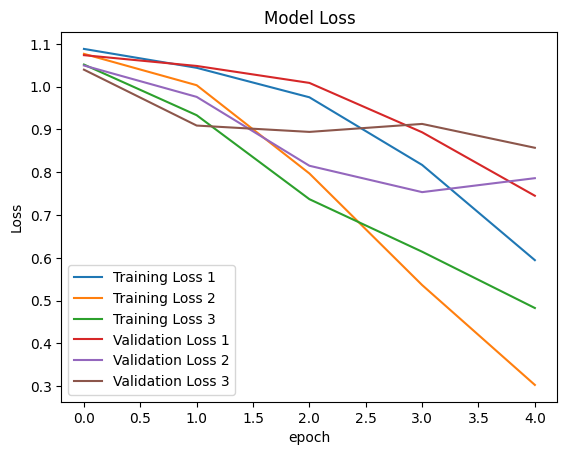

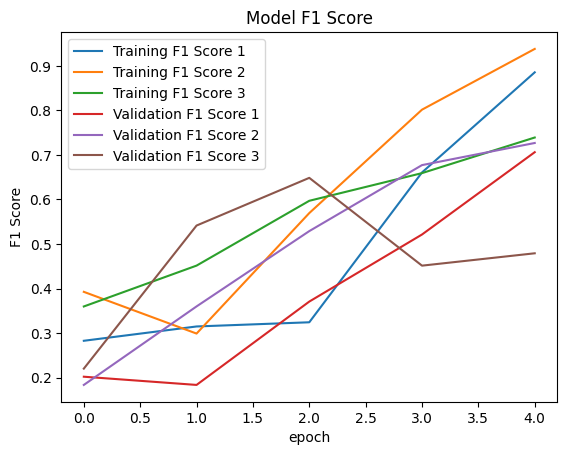

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - f1_score: 0.6400 - loss: 0.8482
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - f1_score: 0.6370 - loss: 0.9428
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - f1_score: 0.5367 - loss: 0.7731
Test accuracy 1: 0.6437
Test accuracy 2: 0.6526
Test accuracy 3: 0.5486


In [38]:
history_1 = n_layer_1_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = n_layer_2_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_3 = n_layer_3_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_3.history['loss'], label="Training Loss 3")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.plot(history_3.history['val_loss'], label="Validation Loss 3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_3.history['f1_score'], label="Training F1 Score 3")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.plot(history_3.history['val_f1_score'], label="Validation F1 Score 3")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = n_layer_1_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = n_layer_2_model.evaluate(X_test, y_test_cat)
test_loss_3, test_acc_3 = n_layer_3_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")
print(f"Test accuracy 3: {test_acc_3:.4f}")



Peningkatan jumlah layer cenderung meningkatkan performa model, tetapi penggunaan layer yang terlalu banyak dapat menyebabkan overfitting.

## 4.2. Variasi Jumlah Cell

### 4.2.1. Modeling

#### 4.2.1.1 Model 1

In [39]:
n_cell_1_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(32, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_1_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.2.1.2 Model 2

In [40]:
n_cell_2_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(128, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_2_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.2.1.3 Model 3

In [41]:
n_cell_3_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(LSTM(512, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

n_cell_3_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.2.2. Comparison and Analysis

Epoch 1/5


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - f1_score: 0.4800 - loss: 1.0894 - val_f1_score: 0.3697 - val_loss: 1.0639
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - f1_score: 0.3832 - loss: 1.0198 - val_f1_score: 0.3186 - val_loss: 0.9720
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - f1_score: 0.4359 - loss: 0.8443 - val_f1_score: 0.5280 - val_loss: 0.8634
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - f1_score: 0.8468 - loss: 0.6212 - val_f1_score: 0.6096 - val_loss: 0.7535
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - f1_score: 0.9117 - loss: 0.3886 - val_f1_score: 0.6999 - val_loss: 0.7587
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - f1_score: 0.4724 - loss: 1.0847 - val_f1_score: 0.1980 - val_loss: 1.0282
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - f1_score: 0.3703 - loss: 0.9445 - val_f1_score: 0.4846 - val_loss: 0.9125
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - f1_score: 0.7897 - loss: 0.6776 - val_f1_score: 0.5567 - val_loss: 0.70

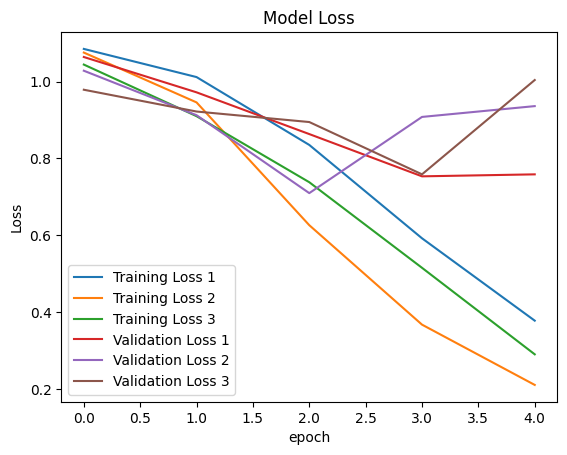

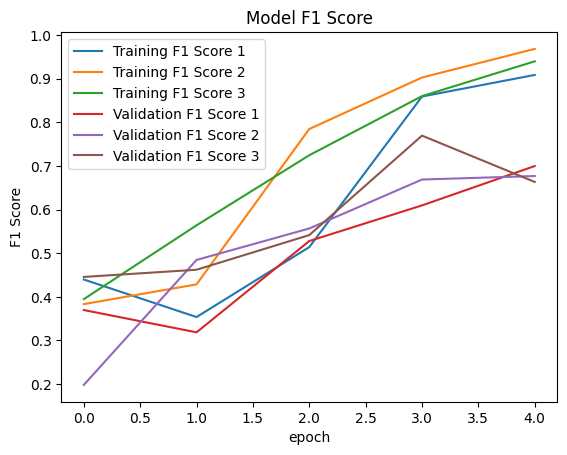

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - f1_score: 0.6668 - loss: 0.7436
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - f1_score: 0.6731 - loss: 1.0555
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 318ms/step - f1_score: 0.5920 - loss: 1.3217
Test accuracy 1: 0.6671
Test accuracy 2: 0.6861
Test accuracy 3: 0.6217


In [42]:
history_1 = n_cell_1_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = n_cell_2_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_3 = n_cell_3_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_3.history['loss'], label="Training Loss 3")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.plot(history_3.history['val_loss'], label="Validation Loss 3")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_3.history['f1_score'], label="Training F1 Score 3")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.plot(history_3.history['val_f1_score'], label="Validation F1 Score 3")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = n_cell_1_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = n_cell_2_model.evaluate(X_test, y_test_cat)
test_loss_3, test_acc_3 = n_cell_3_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")
print(f"Test accuracy 3: {test_acc_3:.4f}")

Peningkatan ukuran layer (cell size) cenderung meningkatkan performa model, tetapi peningkatan yang terlalu banyak dapat menyebabkan overfitting.

## 4.3. Variasi Arah

### 4.3.1. Modeling

#### 4.3.1.1 Model 1

In [43]:
unidirectional_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True,embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    LSTM(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    LSTM(32, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    LSTM(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    Dropout(0.5, seed=42),
    Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

unidirectional_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

#### 4.3.1.2 Model 2

In [44]:
bidirectional_model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=True,embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    Bidirectional(keras.layers.LSTM(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(keras.layers.LSTM(32, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Bidirectional(keras.layers.LSTM(16, kernel_initializer=keras.initializers.GlorotNormal(seed=42))),
    Dropout(0.5, seed=42),
    keras.layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

bidirectional_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

### 4.3.2. Comparison and Analysis

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 234ms/step - f1_score: 0.5319 - loss: 1.0825 - val_f1_score: 0.1836 - val_loss: 1.0224
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - f1_score: 0.3005 - loss: 0.9746 - val_f1_score: 0.5002 - val_loss: 0.9657
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - f1_score: 0.6248 - loss: 0.8691 - val_f1_score: 0.5432 - val_loss: 0.9176
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - f1_score: 0.7387 - loss: 0.7211 - val_f1_score: 0.4895 - val_loss: 0.9115
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - f1_score: 0.8929 - loss: 0.4900 - val_f1_score: 0.7173 - val_loss: 0.7907
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 19s 313ms/step - f1_score: 0.4821 - loss: 1.0792 - val_f1_score: 0.1836 - val_loss: 1.0446
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - f1_score: 0.2955 - loss: 0.9749 - val_f1_score: 0.5394 - val_loss: 0.9507
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step - f1_score: 0.8367 - loss: 0.7937 - val_f1_score: 0.7504 -

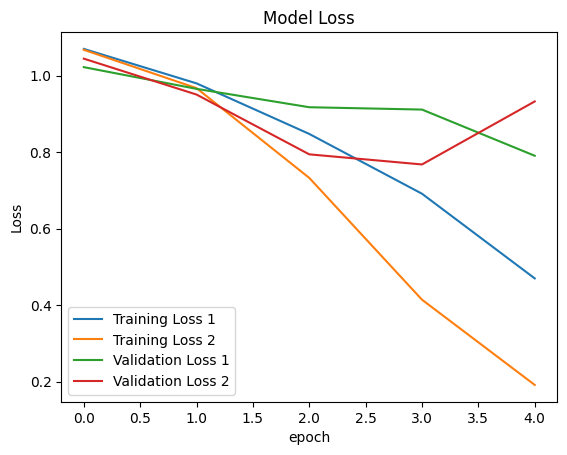

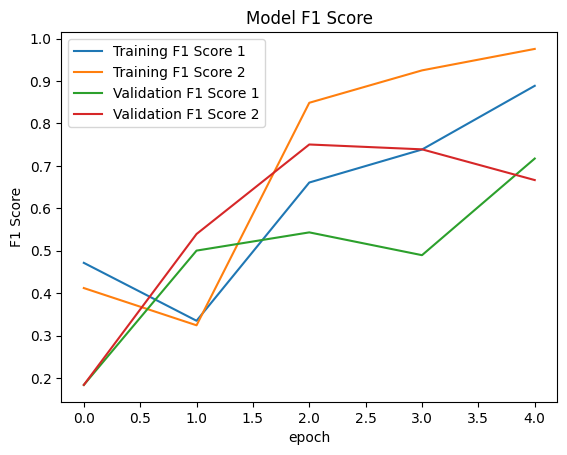

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - f1_score: 0.6951 - loss: 0.7752
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - f1_score: 0.6661 - loss: 0.9953
Test accuracy 1: 0.6965
Test accuracy 2: 0.6629


In [45]:
history_1 = unidirectional_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)
history_2 = bidirectional_model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

plt.plot(history_1.history['loss'], label="Training Loss 1")
plt.plot(history_2.history['loss'], label="Training Loss 2")
plt.plot(history_1.history['val_loss'], label="Validation Loss 1")
plt.plot(history_2.history['val_loss'], label="Validation Loss 2")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(history_1.history['f1_score'], label="Training F1 Score 1")
plt.plot(history_2.history['f1_score'], label="Training F1 Score 2")
plt.plot(history_1.history['val_f1_score'], label="Validation F1 Score 1")
plt.plot(history_2.history['val_f1_score'], label="Validation F1 Score 2")
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend()
plt.show()

test_loss_1, test_acc_1 = unidirectional_model.evaluate(X_test, y_test_cat)
test_loss_2, test_acc_2 = bidirectional_model.evaluate(X_test, y_test_cat)
print(f"Test accuracy 1: {test_acc_1:.4f}")
print(f"Test accuracy 2: {test_acc_2:.4f}")



Tidak terdapat perbedaan signifikan antara Unidirectional layer maupun Bidirectional layer. Tergantung dengan 'seed' yang diperoleh, Unidirectional layer mampu memberikan hasil yang lebih baik daripada Bidirectional layer, demikian jgua sebalikyna. Namun, Bidirectional layer cenderung memberi hasil yang lebih baik daripada Unidirectional layer. Hal ini mungkin dikarenakan persoalan pemrosesan kalimat, seperti penentuan sentimen, cenderung membutuhkan konteks dari kedua sisi kalimat, tetapi tidak secara signifikan.

# 5. Model from Scratch

## 5.1. Modeling

In [ ]:
class LSTM:
    def __init__(self, input_dim, n_cell, return_sequences = False):
        self.input_dim = input_dim
        self. n_cell = n_cell
        self.W, self.U, self.b = None, None, None
        self.return_sequences = return_sequences

    def load_weights(self, layer):
        weights = layer.get_weights()
        self.U = weights[0] # (input_dim, n_cell*4)
        self.W = weights[1] # (n_cell, n_cell*4)
        self.b = weights[2] # (1, n_cell*4)

        self.U_i, self.U_f, self.U_c, self.U_o = np.hsplit(self.U, 4) # (input_dim, n_cell)  # weight for input for each layer
        self.W_i, self.W_f, self.W_c, self.W_o = np.hsplit(self.W, 4) # (n_cell, n_cell)
        self.b_i, self.b_f, self.b_c, self.b_o = np.split(self.b, 4) # (1, n_cell)

    def sigmoid(self, x): return 1 / (1 + np.exp(-x))
    def tanh(self, x): return np.tanh(x)

    def forward(self, input):
        # input = (n_input, input_dim)
        h_t = np.zeros((self.n_cell,))
        c_t = np.zeros((self.n_cell,))

        h_outputs = []

        for x_t in input:
            f_t = self.sigmoid(np.dot(x_t, self.U_f) + np.dot(h_t, self.W_f) + self.b_f)

            i_t = self.sigmoid(np.dot(x_t, self.U_i) + np.dot(h_t, self.W_i) + self.b_i)
            a_t = self.tanh(np.dot(x_t, self.U_c) + np.dot(h_t, self.W_c) + self.b_c)

            o_t = self.sigmoid(np.dot(x_t, self.U_o) + np.dot(h_t, self.W_o) + self.b_o)

            c_t = c_t * f_t + i_t * a_t
            h_t = o_t * self.tanh(c_t)

            if self.return_sequences:
                h_outputs.append(h_t.copy())

        if self.return_sequences:
            return np.stack(h_outputs) # (n_input, n_cell)
        return h_t # (n_cell,)


In [47]:
class Model:
    def __init__(self):
        self.layers = []
        self.input_dim = None

    def load_model(self, model, input_dim):
        lstm_layers = [layer for layer in model.layers if layer.name.startswith("lstm")]
        prev_units_dim = input_dim
        for layer in lstm_layers:
            input_dim = prev_units_dim
            lstm = LSTM(input_dim=input_dim, n_cell=layer.units, return_sequences=layer.return_sequences)
            lstm.load_weights(layer)
            self.layers.append(lstm)
            prev_units_dim = layer.units

    def forward(self, x_seq):
        # iterates up (through layers)
        output = x_seq
        for lstm in self.layers:
            output = lstm.forward(output)
        return output
    
    def predict(self, X_batch):
        return np.stack([self.forward(x_seq) for x_seq in X_batch])

In [48]:
class Dense:
    def __init__(self, weights, bias):
        self.weights = weights
        self.biases = bias

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=-1, keepdims=True)
    
    def forward(self, x):
        z = np.dot(x, self.weights) + self.biases
        return self.softmax(z)

In [49]:
class Embedder:
    def __init__(self, weights):
        self.weights = weights

    def forward(self, X_vectorized):
        return self.weights[X_vectorized]

## 5.2. Comparison & Analysis

In [50]:
model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=False, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    keras.layers.LSTM(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.LSTM(32, return_sequences=False, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[f1]
)

model.fit(X_train, y_train_cat, validation_data = (X_val, y_val_cat), epochs=5, batch_size=32)

model.save_weights("./weight.weights.h5", overwrite=True)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - f1_score: 0.5281 - loss: 1.0856 - val_f1_score: 0.1836 - val_loss: 1.0787
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - f1_score: 0.1860 - loss: 1.0754 - val_f1_score: 0.1836 - val_loss: 1.0790
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - f1_score: 0.1860 - loss: 1.0716 - val_f1_score: 0.1836 - val_loss: 1.0779
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - f1_score: 0.1860 - loss: 1.0688 - val_f1_score: 0.1836 - val_loss: 1.0779
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - f1_score: 0.1860 - loss: 1.0694 - val_f1_score: 0.1836 - val_loss: 1.0779


In [51]:
model_load = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_tokens, output_dim=64, mask_zero=False, embeddings_initializer=keras.initializers.RandomUniform(seed=42)),
    keras.layers.LSTM(64, return_sequences=True, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.LSTM(32, return_sequences=False, kernel_initializer=keras.initializers.GlorotNormal(seed=42)),
    keras.layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.GlorotNormal(seed=42))
])

model_load.build(input_shape=(None, ))

model_load.load_weights("./weight.weights.h5")

In [ ]:
lstm_layer = model_load.layers[2]
print(lstm_layer.name)
print(lstm_layer.units)

lstm_weights = lstm_layer.get_weights()

U = lstm_weights[0] # (input_dim, n_cell*4)
W = lstm_weights[1] # (n_cell, n_cell*4)
b = lstm_weights[2] # (1, n_cell*4)
# print(U, "\n")

U_i, U_f, U_c, U_o = np.hsplit(U, 4) # (input_dim, n_cell)  # weight for input for each layer
W_i, W_f, W_c, W_o = np.hsplit(W, 4) # (n_cell, n_cell)
b_i, b_f, b_c, b_o = np.split(b, 4) # (1, n_cell)
# print(U_i)

lstm_37
64
[[ 0.01082379 -0.13603804  0.01433039 ... -0.01890819  0.06613317
   0.01202655]
 [-0.02569726  0.02090601 -0.03027455 ... -0.01944082  0.07986837
   0.06316219]
 [ 0.02842645  0.03696585 -0.14334655 ... -0.01639487  0.12703495
   0.03903843]
 ...
 [-0.01312779  0.00392823  0.04437549 ...  0.04093418  0.06421869
  -0.03011523]
 [ 0.17131317 -0.021312   -0.1278923  ...  0.05468975  0.11117239
  -0.04185992]
 [-0.03287575  0.04785959 -0.13325176 ...  0.04291979 -0.05265726
  -0.05449559]] 

[[ 0.01082379 -0.13603804  0.01433039 ...  0.08986103  0.06710902
   0.10200971]
 [-0.02569726  0.02090601 -0.03027455 ... -0.12282594 -0.1173527
   0.08968758]
 [ 0.02842645  0.03696585 -0.14334655 ... -0.09234611 -0.03287274
   0.13559705]
 ...
 [-0.01312779  0.00392823  0.04437549 ...  0.00378756  0.07051001
   0.06180055]
 [ 0.17131317 -0.021312   -0.1278923  ... -0.12428894 -0.03850918
  -0.03721818]
 [-0.03287575  0.04785959 -0.13325176 ... -0.02537389  0.04234258
   0.04317831]]


In [53]:
X_test_vectorized = vectorize_layer(np.array(X_test))
print(X_test_vectorized)

tf.Tensor(
[[ 243    7  273 ...    0    0    0]
 [ 513  419  528 ...    0    0    0]
 [2163   84   25 ...    0    0    0]
 ...
 [  66   75   13 ...    0    0    0]
 [ 684  130   72 ...    0    0    0]
 [ 117   39  125 ...    0    0    0]], shape=(400, 100), dtype=int64)


In [54]:
embed_layer = model_load.layers[1]
print(embed_layer.name)

embed_weight = embed_layer.get_weights()[0]
print(embed_weight)

embedding_14
[[-0.01741315 -0.01994916  0.02559526 ...  0.00889319 -0.02060599
   0.05875576]
 [ 0.00810357 -0.03080751  0.00504231 ...  0.03073648  0.00096836
  -0.00115291]
 [-0.00199977  0.06049038  0.03360095 ... -0.04123173  0.00168998
   0.01506051]
 ...
 [ 0.04691004 -0.03176409 -0.04656125 ... -0.02658039 -0.02269635
   0.01508906]
 [-0.04883511  0.00909425 -0.04008238 ... -0.04232666  0.0442853
  -0.03144752]
 [ 0.01975579 -0.04435251 -0.03969564 ...  0.01015823  0.00402246
   0.04052125]]


In [55]:
dense_layer = model_load.layers[4] # change as needed
print(dense_layer.name)

dense_weight = dense_layer.get_weights()[0]
print(dense_weight.shape)
print(dense_weight)

dense_bias = dense_layer.get_weights()[1]
print(dense_bias.shape)
print(dense_bias)

dense_16
(32, 3)
[[ 0.00792201 -0.4316208   0.02640729]
 [ 0.2280715  -0.00910356  0.03483483]
 [ 0.00902783 -0.04247626 -0.01250113]
 [ 0.27255163 -0.10440776  0.03125865]
 [ 0.2233103  -0.37136993 -0.14700672]
 [-0.04267887  0.08972635  0.06393622]
 [ 0.3678687   0.25685742  0.26121533]
 [-0.34262425 -0.14172271  0.26403445]
 [ 0.23118687  0.20067638 -0.3077841 ]
 [-0.51921403  0.32531598 -0.290653  ]
 [-0.15119109  0.23048106 -0.265232  ]
 [ 0.14262483 -0.3450659  -0.04305054]
 [-0.23574595 -0.21344902 -0.30123582]
 [-0.11027695 -0.37758672  0.24251612]
 [ 0.33016694  0.09263369 -0.20000122]
 [ 0.08143797  0.11207937 -0.1355426 ]
 [ 0.25389388  0.0832168   0.01640769]
 [ 0.15401477 -0.47442144 -0.05235346]
 [-0.13890034  0.2010011  -0.2543352 ]
 [-0.08237042 -0.08541287  0.4071369 ]
 [-0.40440828  0.26556766  0.16592395]
 [ 0.26158923  0.22143546  0.20698452]
 [-0.18489167  0.4996975  -0.14814836]
 [ 0.31973395  0.45668727 -0.08678547]
 [ 0.09407575  0.08799026 -0.2259317 ]
 [-0.379

In [56]:
# Embedder
embedder = Embedder(embed_weight)
embed_result = embedder.forward(X_vectorized=X_test_vectorized)
print(embed_result.shape)
print("Embedder output: \n", embed_result)

(400, 100, 64)
Embedder output: 
 [[[-0.01446902 -0.04833935 -0.04673849 ...  0.02642216  0.03997398
    0.01326824]
  [ 0.03240004 -0.0307071  -0.0438515  ... -0.04934743 -0.03680582
    0.03413231]
  [-0.02159681 -0.01850976  0.03774819 ... -0.03754833  0.02374023
    0.01087555]
  ...
  [-0.01741315 -0.01994916  0.02559526 ...  0.00889319 -0.02060599
    0.05875576]
  [-0.01741315 -0.01994916  0.02559526 ...  0.00889319 -0.02060599
    0.05875576]
  [-0.01741315 -0.01994916  0.02559526 ...  0.00889319 -0.02060599
    0.05875576]]

 [[-0.01821201 -0.03636097 -0.02211117 ...  0.01073357 -0.02865957
    0.02994035]
  [-0.00513501 -0.01626264  0.02060487 ...  0.04717237 -0.00460242
   -0.04065262]
  [ 0.02625389 -0.03462327 -0.02776144 ...  0.03301903 -0.01274353
    0.04497571]
  ...
  [-0.01741315 -0.01994916  0.02559526 ...  0.00889319 -0.02060599
    0.05875576]
  [-0.01741315 -0.01994916  0.02559526 ...  0.00889319 -0.02060599
    0.05875576]
  [-0.01741315 -0.01994916  0.02559526 

In [57]:
# LSTM
scratch = Model()
scratch.load_model(model_load, embed_result.shape[-1])

lstm_output = scratch.predict(embed_result)
print(lstm_output.shape)
print("LSTM output:\n", lstm_output)

(400, 32)
LSTM output:
 [[ 0.07312094  0.04938554  0.00553914 ... -0.00463277 -0.06689053
  -0.03458747]
 [ 0.07312094  0.04938565  0.00553914 ... -0.00463296 -0.06689039
  -0.03458765]
 [ 0.07312095  0.04938557  0.00553915 ... -0.00463282 -0.06689049
  -0.03458753]
 ...
 [ 0.07311516  0.04937821  0.0055905  ... -0.00460173 -0.06688778
  -0.034585  ]
 [ 0.07312094  0.04938565  0.00553913 ... -0.00463297 -0.0668904
  -0.03458764]
 [ 0.07312098  0.04938543  0.00553942 ... -0.00463248 -0.06689054
  -0.03458739]]


In [58]:
# Dense
dense = Dense(dense_weight, dense_bias)
dense_output = dense.forward(lstm_output)
print(dense_output.shape)
print("Dense output: \n", dense_output)

(400, 3)
Dense output: 
 [[0.38164076 0.24307485 0.37528438]
 [0.38164076 0.24307491 0.37528434]
 [0.38164076 0.24307487 0.37528437]
 ...
 [0.38163206 0.24306858 0.37529936]
 [0.38164076 0.24307491 0.37528434]
 [0.38164077 0.24307478 0.37528446]]


In [59]:
model_pred = model_load.predict(X_test)

print(model_pred.shape)
print(model_pred)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
(400, 3)
[[0.38164076 0.24307492 0.37528437]
 [0.38164073 0.24307497 0.37528434]
 [0.38164073 0.24307492 0.37528434]
 ...
 [0.38163203 0.2430686  0.37529933]
 [0.38164073 0.24307497 0.37528434]
 [0.38164076 0.24307483 0.37528446]]


In [60]:
from sklearn.metrics import f1_score

model_pred_labeled = np.argmax(model_pred, axis=1)
scratch_pred_labeled = np.argmax(dense_output, axis=1)
y_true = np.argmax(y_test_cat, axis=1)  # if using categorical labels


In [61]:
f1_model = f1_score(y_true, model_pred_labeled, average='macro')
f1_scratch = f1_score(y_true, scratch_pred_labeled, average='macro')

print(f1_model)
print(f1_scratch)

0.1844484629294756
0.1844484629294756


Model 'from scratch' dan model dari keras menghasilkan nilai prediksi yang hampir sama dan memiliki f1_score yang sama. Dari hal ini, dapat disimpulkan bahwa model LSTM 'from scratch' sudah dapat melakukan forward propagation dengan benar